In [20]:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import barnard_exact, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [51]:
transplantation_date = pd.to_datetime('2024-02-02')

data = pd.read_csv('data.csv')
data['height_date_1'] = pd.to_datetime(data['height_date_1'], format="%d/%m/%Y")
data['height_date_2'] = pd.to_datetime(data['height_date_2'], format="%d/%m/%Y")
display(data.head())
display(data.info())

,plant_id,bed_id,bed_type,out_survive,height_a_1,height_b_1,height_date_1,height_a_2,height_b_2,height_date_2
0,1,A,no-dig,1,70.0,69.0,2024-03-07,120.0,125.0,2024-04-01
1,2,B,dig,1,70.0,77.0,2024-03-07,104.0,105.0,2024-04-01
2,3,A,no-dig,0,NaN,NaN,NaT,NaN,NaN,2024-04-01
3,4,B,dig,1,75.0,75.0,2024-03-07,115.0,114.0,2024-04-01
4,5,C,dig,1,131.0,135.0,2024-03-07,205.0,206.0,2024-04-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   plant_id       12 non-null     int64         
 1   bed_id         12 non-null     object        
 2   bed_type       12 non-null     object        
 3   out_survive    12 non-null     int64         
 4   height_a_1     9 non-null      float64       
 5   height_b_1     9 non-null      float64       
 6   height_date_1  9 non-null      datetime64[ns]
 7   height_a_2     9 non-null      float64       
 8   height_b_2     9 non-null      float64       
 9   height_date_2  12 non-null     datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(2), object(2)
memory usage: 1.1+ KB


None

# Live to harvest

In [52]:
survival_contingency = pd.crosstab(data.bed_type, data.out_survive)
survival_contingency

out_survive,0,1
bed_type,,
dig,1,5
no-dig,2,4


In [53]:
barnard_exact(survival_contingency, alternative='two-sided', pooled=False, n=32)
# Barnard becuase it is more powerful than Fisher and only one margin is fixed
# unpooled as unknown if variences are the same for each group. Pooling assumes the same varience. https://cran.r-project.org/web/packages/Exact/Exact.pdf , https://stats.stackexchange.com/questions/169864/which-test-for-cross-table-analysis-boschloo-or-barnard

BarnardExactResult(statistic=-0.6974858324629157, pvalue=0.7291618462276042)

## Height

In [54]:
for x in ['1', '2']:
    data['height_mean_'+x] = (data['height_a_'+x]+data['height_b_'+x])/2
    data['height_day_'+x] = data['height_date_'+x] - transplantation_date
    data['height_day_str_'+x] = data['height_day_'+x].apply(str)
data

,plant_id,bed_id,bed_type,out_survive,height_a_1,height_b_1,height_date_1,height_a_2,height_b_2,height_date_2,height_mean_1,height_day_1,height_day_str_1,height_mean_2,height_day_2,height_day_str_2
0,1,A,no-dig,1,70.0,69.0,2024-03-07,120.0,125.0,2024-04-01,69.5,34 days,34 days 00:00:00,122.5,59 days,59 days 00:00:00
1,2,B,dig,1,70.0,77.0,2024-03-07,104.0,105.0,2024-04-01,73.5,34 days,34 days 00:00:00,104.5,59 days,59 days 00:00:00
2,3,A,no-dig,0,NaN,NaN,NaT,NaN,NaN,2024-04-01,NaN,NaT,NaT,NaN,59 days,59 days 00:00:00
3,4,B,dig,1,75.0,75.0,2024-03-07,115.0,114.0,2024-04-01,75.0,34 days,34 days 00:00:00,114.5,59 days,59 days 00:00:00
4,5,C,dig,1,131.0,135.0,2024-03-07,205.0,206.0,2024-04-01,133.0,34 days,34 days 00:00:00,205.5,59 days,59 days 00:00:00
5,6,D,no-dig,0,NaN,NaN,NaT,NaN,NaN,2024-04-01,NaN,NaT,NaT,NaN,59 days,59 days 00:00:00
6,7,C,dig,0,NaN,NaN,NaT,NaN,NaN,2024-04-01,NaN,NaT,NaT,NaN,59 days,59 days 00:00:00
7,8,D,no-dig,1,113.0,114.0,2024-03-07,161.0,171.0,2024-04-01,113.5,34 days,34 days 00:00:00,166.0,59 days,59 days 00:00:00
8,9,E,dig,1,113.0,112.0,2024-03-07,151.0,151.0,2024-04-01,112.5,34 days,34 days 00:00:00,151.0,59 days,59 days 00:00:00
9,10,E,dig,1,70.0,70.0,2024-03-07,92.0,90.0,2024-04-01,70.0,34 days,34 days 00:00:00,91.0,59 days,59 days 00:00:00


c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


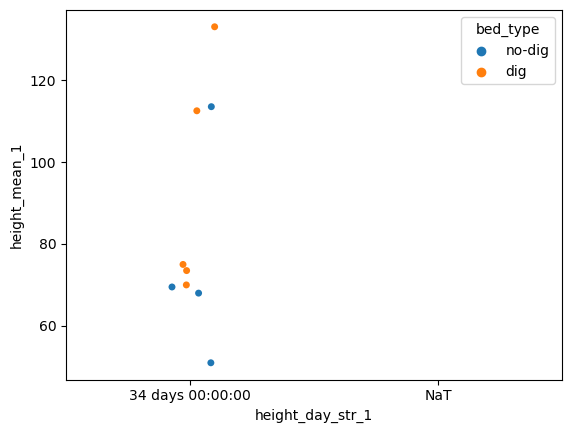

In [55]:
sns.stripplot(data=data, y='height_mean_1', x='height_day_str_1', hue='bed_type', jitter=True)
plt.show()

c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


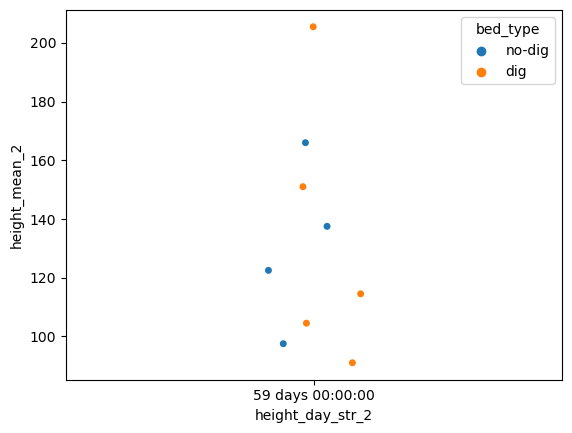

In [56]:
sns.stripplot(data=data, y='height_mean_2', x='height_day_str_2', hue='bed_type', jitter=True)
plt.show()

In [57]:
#30 (34) day
a = data[((data['bed_type']=='dig')&(data['height_mean_1'].isna()==False))]['height_mean_1']
b = data[((data['bed_type']=='no-dig')&(data['height_mean_1'].isna()==False))]['height_mean_1']
ttest_ind(a=a, b=b, equal_var=True, nan_policy='raise', permutations=None, alternative='two-sided', trim=0)

TtestResult(statistic=0.9328677792620035, pvalue=0.3819387891001678, df=7.0)

In [58]:
#60 (59) day
a = data[((data['bed_type']=='dig')&(data['height_mean_2'].isna()==False))]['height_mean_2']
b = data[((data['bed_type']=='no-dig')&(data['height_mean_2'].isna()==False))]['height_mean_2']
ttest_ind(a=a, b=b, equal_var=True, nan_policy='raise', permutations=None, alternative='two-sided', trim=0)

TtestResult(statistic=0.09135860860740895, pvalue=0.9297670668375285, df=7.0)

In [59]:
data['height_date_2']

0    2024-04-01
1    2024-04-01
2    2024-04-01
3    2024-04-01
4    2024-04-01
5    2024-04-01
6    2024-04-01
7    2024-04-01
8    2024-04-01
9    2024-04-01
10   2024-04-01
11   2024-04-01
Name: height_date_2, dtype: datetime64[ns]

In [60]:
data

,plant_id,bed_id,bed_type,out_survive,height_a_1,height_b_1,height_date_1,height_a_2,height_b_2,height_date_2,height_mean_1,height_day_1,height_day_str_1,height_mean_2,height_day_2,height_day_str_2
0,1,A,no-dig,1,70.0,69.0,2024-03-07,120.0,125.0,2024-04-01,69.5,34 days,34 days 00:00:00,122.5,59 days,59 days 00:00:00
1,2,B,dig,1,70.0,77.0,2024-03-07,104.0,105.0,2024-04-01,73.5,34 days,34 days 00:00:00,104.5,59 days,59 days 00:00:00
2,3,A,no-dig,0,NaN,NaN,NaT,NaN,NaN,2024-04-01,NaN,NaT,NaT,NaN,59 days,59 days 00:00:00
3,4,B,dig,1,75.0,75.0,2024-03-07,115.0,114.0,2024-04-01,75.0,34 days,34 days 00:00:00,114.5,59 days,59 days 00:00:00
4,5,C,dig,1,131.0,135.0,2024-03-07,205.0,206.0,2024-04-01,133.0,34 days,34 days 00:00:00,205.5,59 days,59 days 00:00:00
5,6,D,no-dig,0,NaN,NaN,NaT,NaN,NaN,2024-04-01,NaN,NaT,NaT,NaN,59 days,59 days 00:00:00
6,7,C,dig,0,NaN,NaN,NaT,NaN,NaN,2024-04-01,NaN,NaT,NaT,NaN,59 days,59 days 00:00:00
7,8,D,no-dig,1,113.0,114.0,2024-03-07,161.0,171.0,2024-04-01,113.5,34 days,34 days 00:00:00,166.0,59 days,59 days 00:00:00
8,9,E,dig,1,113.0,112.0,2024-03-07,151.0,151.0,2024-04-01,112.5,34 days,34 days 00:00:00,151.0,59 days,59 days 00:00:00
9,10,E,dig,1,70.0,70.0,2024-03-07,92.0,90.0,2024-04-01,70.0,34 days,34 days 00:00:00,91.0,59 days,59 days 00:00:00


In [63]:
measurements = pd.wide_to_long(data,['height_mean', 'height_day_str'], i='plant_id', j='measurement_number', sep='_').reset_index()
measurements

,plant_id,measurement_number,bed_type,height_b_1,height_date_1,height_a_1,height_date_2,out_survive,height_b_2,height_day_1,height_a_2,height_day_2,bed_id,height_mean,height_day_str
0,1,1,no-dig,69.0,2024-03-07,70.0,2024-04-01,1,125.0,34 days,120.0,59 days,A,69.5,34 days 00:00:00
1,2,1,dig,77.0,2024-03-07,70.0,2024-04-01,1,105.0,34 days,104.0,59 days,B,73.5,34 days 00:00:00
2,3,1,no-dig,NaN,NaT,NaN,2024-04-01,0,NaN,NaT,NaN,59 days,A,NaN,NaT
3,4,1,dig,75.0,2024-03-07,75.0,2024-04-01,1,114.0,34 days,115.0,59 days,B,75.0,34 days 00:00:00
4,5,1,dig,135.0,2024-03-07,131.0,2024-04-01,1,206.0,34 days,205.0,59 days,C,133.0,34 days 00:00:00
5,6,1,no-dig,NaN,NaT,NaN,2024-04-01,0,NaN,NaT,NaN,59 days,D,NaN,NaT
6,7,1,dig,NaN,NaT,NaN,2024-04-01,0,NaN,NaT,NaN,59 days,C,NaN,NaT
7,8,1,no-dig,114.0,2024-03-07,113.0,2024-04-01,1,171.0,34 days,161.0,59 days,D,113.5,34 days 00:00:00
8,9,1,dig,112.0,2024-03-07,113.0,2024-04-01,1,151.0,34 days,151.0,59 days,E,112.5,34 days 00:00:00
9,10,1,dig,70.0,2024-03-07,70.0,2024-04-01,1,90.0,34 days,92.0,59 days,E,70.0,34 days 00:00:00


c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


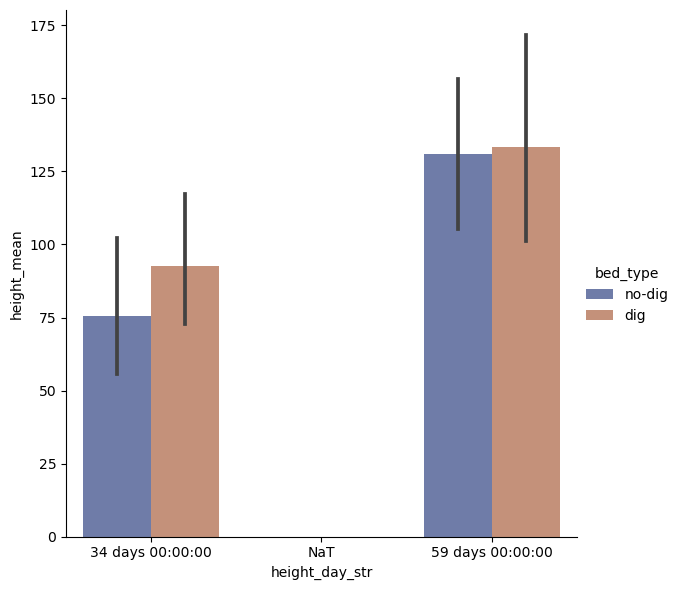

In [65]:
sns.catplot(
    data=measurements, kind="bar",
    x="height_day_str", y="height_mean", hue="bed_type",
    errorbar=("ci", 95), palette="dark", alpha=.6, height=6
)